In [1]:
# Stanisław Wilczyński project1
import sys
from time import time

import numpy as np

%pylab inline
from __future__ import print_function
STEPS = 2 * 10**3

Populating the interactive namespace from numpy and matplotlib


In [9]:
def loss(a, x, y):
    xb = np.dot(x, a)
    return np.sum(np.log(1 + np.exp(xb)) - np.multiply(y, xb))


def generate_data(n, d, ro, option, debug=False):
    mean = np.zeros(d)
    if option == 'independent':
        cov = np.identity(d)
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)
    if option == 'same_corr':
        cov = np.ones((d, d)) * ro + np.identity(d) * (1 - ro)
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)
    if option == 'auto_corr':
        cov = [[ro ** np.abs(i - j) for i in range(d)] for j in range(d)]
        if debug:
            print('Mean and covariance {} \n {}'.format(mean, cov))
        return np.random.multivariate_normal(mean, cov, n)

    raise Exception('Wrong option')


def generate_response(X, beta, debug=False):
    p = np.exp(np.dot(X, beta)) / (1 + np.exp(np.dot(X, beta)))
    if debug:
        print('Probability\n', p)
    return np.random.binomial(1, p).reshape(-1, 1)


# proximal for lambda penalty - as in the lecture
def proximal(a, step, lam):
    d = a.shape[0]
    return np.multiply(np.sign(a), np.maximum((np.abs(a) - lam * step), np.zeros((d, 1))))


# gradient step for logistic regression model - as in project
def grad_step(a, x, y, step=0.01):
    n = x.shape[0]
    p = np.exp(np.dot(x, a)) / (1 + np.exp(np.dot(x, a))).reshape(n, 1)
    grad_a = np.dot(x.T, (p - y))
    return a - step * grad_a


# stochastic gradient step - calculate gradient with respect only to loss connected with randomly chosen x_j
def stochastic_grad_step(a, x, y, step=0.01):
    n = x.shape[0]
    j = np.random.randint(n)
    p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
    grad_a = (p - y[j]) * x[j, :]
    return a - step * grad_a.reshape(-1, 1)


# gradient descent algorithm
def gradient_descent(x, y, epsilon=0.000001, step=0.01, lam=0.01, prox=False, stochastic=False):
    n = x.shape[0]
    d = x.shape[1]
    a = np.random.randn(d).reshape(d, 1)
    losses = []
    prev_loss = sys.maxsize
    curr_loss = 0
    steps = 0
    while (np.abs(curr_loss - prev_loss) > epsilon and steps < STEPS) or steps < STEPS // 4:
        losses += [loss(a, x, y)]
        if stochastic:
            a = stochastic_grad_step(a, x, y, step)
        else:
            a = grad_step(a, x, y, step)
        if prox:
            a = proximal(a, step, lam)
        steps += 1
        prev_loss = curr_loss
        curr_loss = loss(a, x, y)
    return a, losses, steps


# saga algorithm
def saga(x, y, epsilon=0.000001, step=0.01, lam=0.01, prox=False):
    n = x.shape[0]
    d = x.shape[1]
    a = np.random.randn(d).reshape(d, 1)
    p = np.exp(np.dot(x, a)) / (1 + np.exp(np.dot(x, a))).reshape(n, 1)
    M = np.multiply(p - y, x)
    avg = np.mean(M, axis=0)
    losses = []
    prev_loss = sys.maxsize
    curr_loss = 0
    steps = 0
    while (np.abs(curr_loss - prev_loss) > epsilon and steps < STEPS) or steps < STEPS // 4:
        losses += [loss(a, x, y)]
        ####saga step
        j = np.random.randint(n)
        old_deriv = np.array(M[j, :])  # very important copy
        p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
        new_deriv = (p - y[j]) * x[j, :]
        M[j, :] = new_deriv
        a -= step * ((new_deriv - old_deriv + avg).reshape(-1, 1))
        avg += (new_deriv - old_deriv) / n
        if prox:
            a = proximal(a, step, lam)
        ####
        steps += 1
        prev_loss = curr_loss
        curr_loss = loss(a, x, y)
    return a, losses, steps


# svrg algorithm
def svrg(x, y, epsilon=0.000001, step=0.01, lam=0.01, prox=False, T=100):
    n = x.shape[0]
    d = x.shape[1]
    a = np.random.randn(d).reshape(d, 1)
    losses = []
    prev_loss = sys.maxsize
    curr_loss = 0
    steps = 0
    # svrg outer loop
    while (np.abs(curr_loss - prev_loss) > epsilon and steps < STEPS) or steps < STEPS // 4:
        a_avg = np.array(a)
        p = np.exp(np.dot(x, a_avg)) / (1 + np.exp(np.dot(x, a_avg))).reshape(n, 1)
        grad_avg = np.mean(np.multiply(p - y, x), axis=0)
        # svrg inner loop
        for _ in range(T):
            losses += [loss(a, x, y)]
            steps += 1
            j = np.random.randint(n)
            p = np.exp(np.dot(x[j, :], a)) / (1 + np.exp(np.dot(x[j, :], a))).ravel()[0]
            p_avg = np.exp(np.dot(x[j, :], a_avg)) / (1 + np.exp(np.dot(x[j, :], a_avg))).ravel()[0]
            deriv = (p - y[j]) * x[j, :]
            deriv_avg = (p_avg - y[j]) * x[j, :]
            a -= step * ((deriv - deriv_avg + grad_avg).reshape(-1, 1))
            if prox:
                a = proximal(a, step, lam)
            prev_loss = curr_loss
            curr_loss = loss(a, x, y)
    return a, losses, steps


In [14]:
def perform_simulation(n, d, eps, data_generation, step_sizes, lambdas, is_prox=False, start_ind=1):
    print('The data dimensions are n = {} and d = {} and precision = {}'.format(n, d, eps))
    beta = np.random.uniform(-1, 2, d).reshape(-1, 1)  # very important reshape
    if is_prox:
        print('87.5% of betas are set to zero')
        ind = np.random.permutation(np.arange(d))[:-d//8]
        beta[ind] = 0
    print('---------------------------------------------------------------')
    x = generate_data(n, d, 0.9, data_generation)
    y = generate_response(x, beta)
    t1 = time()
    a, losses, steps_count = gradient_descent(x, y, step=step_sizes[0], lam=lambdas[0], prox=is_prox)
    t2 = time()
    print('Gradient descent took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for GD: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for GD')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = gradient_descent(x, y, stochastic=True, step=step_sizes[1], lam=lambdas[1], prox=is_prox)
    t2 = time()
    print('Stochastic gradient descent took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SGD: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SGD')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = saga(x, y, step=step_sizes[2], lam=lambdas[2], prox=is_prox)
    t2 = time()
    print('SAGA took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SAGA: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SAGA')
    print('---------------------------------------------------------------')

    t1 = time()
    a, losses, steps_count = svrg(x, y, step=step_sizes[3], lam=lambdas[3], prox=is_prox)
    t2 = time()
    print('SVRG took {} seconds and performed {} steps'.format(t2-t1, steps_count))
    print('Number of nonzero coeff: {}'.format(np.sum(a != 0)))
    print('Squared error for betas: {}'.format(np.sum((a - beta) ** 2)))
    print('Steps count for SVRG: {}\nThe loss was {}'.format(steps_count, losses[-1]))
    plt.figure(1)
    plt.plot(np.arange(len(losses[start_ind:])), losses[start_ind:], label='Loss for SVRG')

    plt.legend()
    plt.show()

The data dimensions are n = 10000 and d = 50 and precision = 0.0001
---------------------------------------------------------------
Gradient descent took 5.01217412949 seconds and performed 2000 steps
Number of nonzero coeff: 50
Squared error for betas: 38.8226666516
Steps count for GD: 2000
The loss was 1291.50028948
---------------------------------------------------------------
Stochastic gradient descent took 0.912845849991 seconds and performed 514 steps
Number of nonzero coeff: 50
Squared error for betas: 107.132229749
Steps count for SGD: 514
The loss was 3625.45529885
---------------------------------------------------------------
SAGA took 3.47664809227 seconds and performed 2000 steps
Number of nonzero coeff: 50
Squared error for betas: 17.8673761668
Steps count for SAGA: 2000
The loss was 1409.99602151
---------------------------------------------------------------
SVRG took 3.50665402412 seconds and performed 2000 steps
Number of nonzero coeff: 50
Squared error for betas: 2

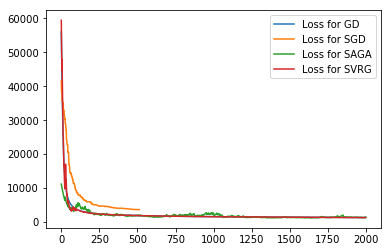

In [22]:
perform_simulation(10**4, 50, 10**(-4), 'auto_corr', [0.000005, 0.02, 0.03, 0.05], [40.1, 0.5, 0.4, 0.08], is_prox=False)

The data dimensions are n = 10000 and d = 50 and precision = 0.0001
87.5% of betas are set to zero
---------------------------------------------------------------
Gradient descent took 1.32094883919 seconds and performed 500 steps
Number of nonzero coeff: 28
Squared error for betas: 0.00985976847519
Steps count for GD: 500
The loss was 6363.15892281
---------------------------------------------------------------
Stochastic gradient descent took 3.68330287933 seconds and performed 2000 steps
Number of nonzero coeff: 18
Squared error for betas: 0.580035307281
Steps count for SGD: 2000
The loss was 6926.60906517
---------------------------------------------------------------
SAGA took 1.9572019577 seconds and performed 1025 steps
Number of nonzero coeff: 0
Squared error for betas: 0.576109131041
Steps count for SAGA: 1025
The loss was 6931.4718056
---------------------------------------------------------------
SVRG took 2.69898581505 seconds and performed 1500 steps
Number of nonzero coef

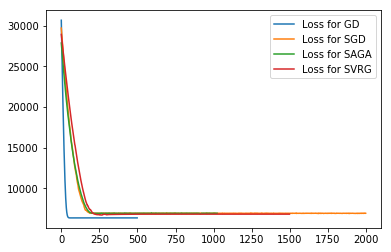

In [19]:
perform_simulation(10**4, 50, 10**(-4), 'independent', [0.00005, 0.02, 0.02, 0.05], [40.1, 0.5, 0.4, 0.08], is_prox=True)

In [ ]:
#dobrac step_size i lambdy dla jednego rozmiaru danych ale wszystkich typow inicjalizacji,
#potem czas bedziemy mierzyc juz bez patrzenia na wyniki i bez wzgledu na lambdy,step_size